In [174]:
import torch

import numpy as np

from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import pandas as pd

import os

from PIL import Image

import torch.nn as nn

from torchvision import transforms

import shutil

import random

import torchvision.models as models

import matplotlib.pyplot as plt

from pathlib import Path

import copy 

from sklearn.metrics import classification_report

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [140]:
class FingersDataset(Dataset):
    def __init__(self,image_paths,labels,transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        label = torch.tensor(label)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image,label
    

    

In [141]:
class FingersDatasetwOrient(Dataset):
    def __init__(self,image_paths,labels,orientations,transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.orientations = orientations
        self.transform = transforms
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        orientation = self.orientations[idx]
        label = torch.tensor(label)
        orientation = torch.tensor(orientation)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, (label,orientation)
    


In [142]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [143]:
test_transforms = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [144]:
def get_label(path):
    return int(path.stem.split('_')[-1][0])
def load_fingers(train_loc,test_loc):
    train_paths = list(Path(train_loc).glob("*.png"))
    train_labels = [get_label(path) for path in train_paths]

    test_paths = list(Path(test_loc).glob("*.png"))
    test_labels = [get_label(path) for path in test_paths]

    print("--------Loading Dataset-------")
    train_dataset = FingersDataset(train_paths, train_labels,transforms = train_transforms)
    test_dataset = FingersDataset(test_paths, test_labels, transforms = test_transforms)
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
    test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)
    print("--------Dataset Loaded---------")

    return len(train_labels), len(test_labels), train_loader, test_loader
    

In [145]:
def get_label_and_orient(path):
    parts = path.stem.split('_')
    finger_label = int(parts[-1][0])
    orient = 0 if parts[-1][1] == 'L' else 1
    return finger_label, orient


def load_fingers_and_orient(train_loc,test_loc):
    train_paths = list(Path(train_loc).glob("*.png"))
    train_labels_orientations = [get_label_and_orient(path) for path in train_paths]
    train_labels = [label for label, _  in train_labels_orientations]
    train_orientations = [orientation for _, orientation in train_labels_orientations]

    test_paths = list(Path(test_loc).glob("*.png"))
    test_labels_orientations = [get_label_and_orient(path) for path in test_paths]
    test_labels = [label for label, _  in test_labels_orientations]
    test_orientations = [orientation for _, orientation in test_labels_orientations]


    print("--------Loading Dataset-------")
    train_dataset = FingersDatasetwOrient(train_paths, train_labels, train_orientations, transforms = train_transforms)
    test_dataset = FingersDatasetwOrient(test_paths, test_labels, test_orientations, transforms = test_transforms)
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
    test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)
    print("--------Dataset Loaded---------")

    return len(train_labels), len(test_labels), train_loader, test_loader
    

In [146]:
BATCH_SIZE = 64
train_loc = "/kaggle/input/assignment2data/assignment2Data/train"
test_loc = "/kaggle/input/assignment2data/assignment2Data/test"
num_train, num_test, train_loader, test_loader = load_fingers(train_loc, test_loc)

--------Loading Dataset-------
--------Dataset Loaded---------


In [147]:
BATCH_SIZE = 64
train_loc = "/kaggle/input/assignment2data/assignment2Data/train"
test_loc = "/kaggle/input/assignment2data/assignment2Data/test"
num_train2, num_test2, train_loader2, test_loader2 = load_fingers_and_orient(train_loc, test_loc)

--------Loading Dataset-------
--------Dataset Loaded---------


In [148]:
print("no_ smaples in train_set", num_train)
print("no_samples in test_set", num_test)

no_ smaples in train_set 18000
no_samples in test_set 3600


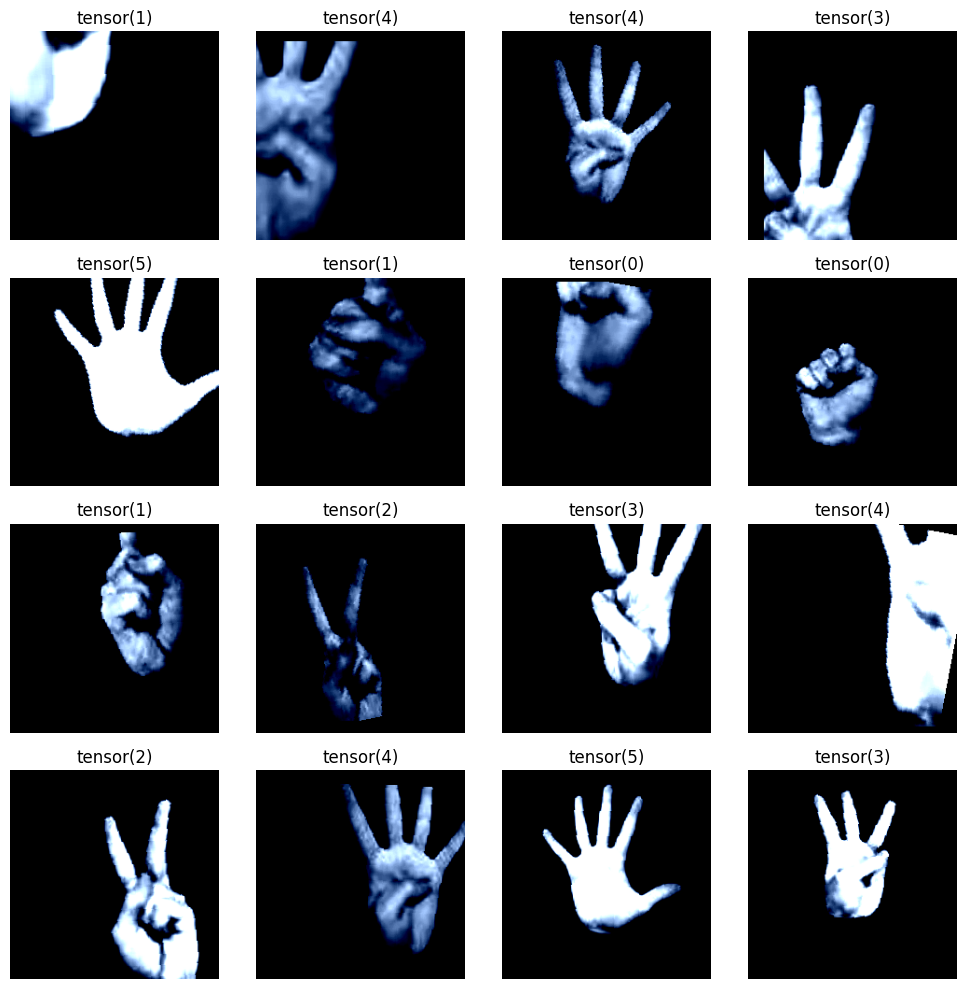

In [149]:
for data, labels in train_loader:
      
    pics_2use = data[:16,:,:,:]
    label = labels[:16]

    fig,axs = plt.subplots(4,4,figsize=(10,10))
    axs = axs.flatten()

    
    for i in range(16):
        axs[i].imshow(pics_2use[i].numpy().transpose(1,2,0)) 
        axs[i].axis('off')
        axs[i].set_title(label[i])
        
    plt.tight_layout()
    plt.show()
    break

In [150]:
#for data, labels in train_loader2:
    
   # check_image = data[:1,:,:,:]
   # print(check_image.mode)

    
   # pics_2use = data[:16,:,:,:]
   # labels_fingers, labels_orientation = zip(*labels[:16])

   # fig,axs = plt.subplots(4,4,figsize=(10,10))
  #  axs = axs.flatten()

    
   # for i in range(16):
     #   axs[i].imshow(pics_2use[i].numpy().transpose(1,2,0)) 
     #   axs[i].axis('off')
     #   axs[i].set_title(f'{labels_fingers[i]}-{"right" if labels_orientation[i] ==1 else "left"}')
        
   # plt.tight_layout()
   # plt.show()
   # break

In [151]:
class basemodel(nn.Module):
    def __init__(self):
      super().__init__()
   

      self.conv1  = nn.Conv2d(3,16,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16)

      self.conv2 = nn.Conv2d(16, 32, 3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(32)
        
      self.conv3  = nn.Conv2d(32,64,3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(64)

      self.conv4 = nn.Conv2d(64, 128,3,padding=1)
      self.bnorm4 = nn.BatchNorm2d(128)
      
      self.fc1 = nn.Linear(14*14*128,256)
      self.fc2 = nn.Linear(256,128)
      self.fc3 = nn.Linear(128, 6)

    def forward(self,x):
        
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))

      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))

      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
    
      x = F.max_pool2d(self.conv4(x),2)
      x = F.leaky_relu(self.bnorm4(x))

      nUnits = x.shape[1] * x.shape[2] * x.shape[3]
      x = x.view(-1,int(nUnits))

      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))


      return x


In [152]:
def train_model(input_model, epochs):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    best_acc = 0
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(input_model.parameters(), lr=0.001)
    input_model.to(device)

    for epoch in range(epochs):
        input_model.train()
        train_loss_sum = 0.0
        train_batches = 0
        train_preds = 0
        train_samps = 0
        for data,labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            y_hat = input_model(data)
            loss = criterion(y_hat, labels)

            loss.backward()
            optimizer.step()

       
            predclass = torch.max(y_hat,1)
            train_samps += predclass[0].size(0)
            train_preds+=(predclass[1] == labels).sum()

            train_loss_sum += loss.item()
            train_batches += 1

        train_losses.append(train_loss_sum/train_batches)    
        acc_per_epoch = train_preds/train_samps *100
        train_acc.append(acc_per_epoch)
        

        input_model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        val_samps = 0
        val_preds = 0
        with torch.no_grad():
            
            for data, labels in test_loader:
                data = data.to(device)
                labels = labels.to(device)
                preds = input_model(data)
                predClass = torch.max(preds,1)
                val_samps+=predClass[0].size(0)
                val_preds+=(predClass[1] == labels).sum()
                loss = criterion(preds,labels)
                val_loss_sum += loss.item()
                val_batches += 1

            val_losses.append(val_loss_sum/ val_batches)
                
            val_accuracy_per_epochs = val_preds/val_samps*100
            val_acc.append(val_accuracy_per_epochs)
            print(f"Epoch:{epoch}")
                
            current_validation_accuracy  =  val_acc[-1]
            if current_validation_accuracy > best_acc:
                best_acc = current_validation_accuracy
                best_model = copy.deepcopy(input_model.state_dict())
        
        
    return train_losses, val_losses, train_acc, val_acc, input_model

In [158]:
def train_model2(input_model, epochs):
    train_losses = []
    val_losses = []
    train_acc_fingers = []
    val_acc_fingers = []
    train_acc_orientation = []
    val_acc_orientation = []

    best_acc = 0
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(input_model.parameters(), lr=0.001)
    input_model.to(device)

    for epoch in range(epochs):
        input_model.train()
        train_loss_sum = 0.0
        train_batches = 0
        train_preds_fingers = 0
        train_preds_orientation = 0
        train_samps = 0
        
        for data, labels in train_loader:
            data = data.to(device)
            labels_fingers, labels_orientation = labels
            labels_fingers = labels_fingers.to(device)
            labels_orientation = labels_orientation.to(device)
            optimizer.zero_grad()

            y_hat_fingers, y_hat_orientation = input_model(data)
            loss_fingers = criterion(y_hat_fingers, labels_fingers)
            loss_orientation = criterion(y_hat_orientation, labels_orientation)
            loss = loss_fingers + loss_orientation

            loss.backward()
            optimizer.step()

            predclass_fingers = torch.max(y_hat_fingers, 1)
            predclass_orientation = torch.max(y_hat_orientation, 1)
            train_samps += predclass_fingers[0].size(0)
            train_preds_fingers += (predclass_fingers[1] == labels_fingers).sum()
            train_preds_orientation += (predclass_orientation[1] == labels_orientation).sum()

            train_loss_sum += loss.item()
            train_batches += 1

        train_losses.append(train_loss_sum / train_batches)    
        acc_fingers_per_epoch = train_preds_fingers.double() / train_samps * 100
        acc_orientation_per_epoch = train_preds_orientation.double() / train_samps * 100
        train_acc_fingers.append(acc_fingers_per_epoch)
        train_acc_orientation.append(acc_orientation_per_epoch)

        input_model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        val_samps = 0
        val_preds_fingers = 0
        val_preds_orientation = 0
        with torch.no_grad():
            
            for data, labels in test_loader:
                data = data.to(device)
                labels_fingers, labels_orientation = labels
                labels_fingers = labels_fingers.to(device)
                labels_orientation = labels_orientation.to(device)
                preds_fingers, preds_orientation = input_model(data)
                predClass_fingers = torch.max(preds_fingers, 1)
                predClass_orientation = torch.max(preds_orientation, 1)
                val_samps += predClass_fingers[0].size(0)
                val_preds_fingers += (predClass_fingers[1] == labels_fingers).sum()
                val_preds_orientation += (predClass_orientation[1] == labels_orientation).sum()
                loss_fingers = criterion(preds_fingers, labels_fingers)
                loss_orientation = criterion(preds_orientation, labels_orientation)
                loss = loss_fingers + loss_orientation
                val_loss_sum += loss.item()
                val_batches += 1

            val_losses.append(val_loss_sum / val_batches)
                
            val_accuracy_fingers_per_epoch = val_preds_fingers.double() / val_samps * 100
            val_accuracy_orientation_per_epoch = val_preds_orientation.double() / val_samps * 100
            val_acc_fingers.append(val_accuracy_fingers_per_epoch)
            val_acc_orientation.append(val_accuracy_orientation_per_epoch)
            print(f"Epoch {epoch}: Fingers Acc - {val_accuracy_fingers_per_epoch:.2f}%, Orientation Acc - {val_accuracy_orientation_per_epoch:.2f}%")
                
            current_validation_accuracy = (val_acc_fingers[-1] + val_acc_orientation[-1]) / 2
            if current_validation_accuracy > best_acc:
                best_acc = current_validation_accuracy
                best_model = copy.deepcopy(input_model.state_dict())
        
    return train_losses, val_losses, train_acc_fingers, val_acc_fingers, train_acc_orientation, val_acc_orientation, input_model


In [154]:
 #weights = torchvision.models.ResNet18_Weights.DEFAULT
#resnet = torchvision.models.resnet18(weights=weights)

In [155]:
base_model = basemodel()

resnet_sc = models.resnet18()
resnet_sc.fc = nn.Linear(resnet_sc.fc.in_features, 6)

resnet_w = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = resnet_w.fc.in_features
resnet_w.fc = nn.Linear(num_features, 6)

In [156]:
stack_models = {'base_model': base_model, 'resnet_sc': resnet_sc, 'resnet_w': resnet_w}

results = {}

no_of_epochs = 5

for model_name, model in stack_models.items():

    train_loss, val_loss, train_acc, val_acc, net = train_model(model,no_of_epochs)

    results[model_name] = {

        'train_loss' : train_loss,

        'val_loss' : val_loss,

        'train_acc': train_acc,

        'val_acc': val_acc,

        'model': net

    }

Epoch:0
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:0
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:0
Epoch:1
Epoch:2
Epoch:3
Epoch:4


In [159]:
rerun = {'base_model': base_model}

second_results = {}

no_of_epochs = 5

for model_name, model in rerun.items():

    train_loss, val_loss, train_acc, val_acc,train_acc_o, val_acc_o,net = train_model2(model,no_of_epochs)

    second_results[model_name] = {

        'train_loss' : train_loss,

        'val_loss' : val_loss,

        'train_acc': train_acc,

        'val_acc': val_acc,
        
        'train_acc-o': train_acc_o,

        'val_acc-o': val_acc_o,

        'model': net

    }

ValueError: too many values to unpack (expected 2)

In [162]:
def plot_loss_and_accuracies(loss_1,loss_2,acc_1,acc_2):
    loss_1 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in loss_1]
    loss_2 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in loss_2] 
    acc_1 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in acc_1] 
    acc_2 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in acc_2]

    fig,ax = plt.subplots(1,2,figsize=(16,5))

    ax[0].plot(loss_1,'-',label='train-loss')

    ax[0].plot(loss_2,'-',label='validation-loss')

    ax[0].set_ylabel('Loss')

    ax[0].set_xlabel('epoch')
    ax[0].legend()
    ax[0].grid(True)
    ax[0].set_title(f"train_loss after 10 epochs: {loss_1[-1]:.2f}, val_loss after 10 epochs:{loss_2[-1]:.2f}")


    ax[1].plot(acc_1,'-',label='train-acc')

    ax[1].plot(acc_2,'-',label='validation-acc')

    ax[1].set_xlabel('epoch')

    ax[1].set_ylabel('Accuracy(%)')
    ax[1].grid(True)

    ax[1].set_title(f'train_acc after 10 epochs: {acc_1[-1]:.2f}%, val_acc after 10 epochs: {acc_2[-1]:.2f}%')

    ax[1].legend()


In [163]:
def test_models(model):
    test_acc
    num_epochs = 1
    model.to(device)
    model.eval()
    for epoch in range(num_epochs):
        test_samps = 0
        test_preds = 0
        test_loss_sum = 0
        test_batches = 0
    
        with torch.no_grad():
            for data,labels in test_loader:  
                data = data.to(device)
                labels = labels.to(device)
                preds = model(data)
                
                predClass = torch.max(preds,1)
                test_samps+=predClass[0].size(0)
                test_preds+=(predClass[1] == labels).sum()
                
                test_batches += 1 
        
            acc_per_epoch = (test_preds/test_samps) * 100
        
            
            #test_loss.append(test_loss_sum/ test_samps)
            test_acc.append(acc_per_epoch)

    return test_acc
        

In [166]:
def test_loss_and_acc(acc, model):
    acc = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in acc]

    plt.plot(acc,'s-',label='test')

    plt.xlabel('no_of_batches')

    plt.ylabel('Accuracy(%)')

    plt.title(f'final {model} test acc: {acc[-1]:.2f}%')

    plt.legend()

    plt.grid(True)


In [167]:
base_train_loss = results['base_model']['train_loss']
base_val_loss = results['base_model']['val_loss']
base_train_acc = results['base_model']['train_acc']
base_val_acc = results['base_model']['val_acc']

sc_train_loss = results['resnet_sc']['train_loss']
sc_val_loss = results['resnet_sc']['val_loss']
sc_train_acc = results['resnet_sc']['train_acc']
sc_val_acc = results['resnet_sc']['val_acc']

tf_train_loss = results['resnet_w']['train_loss']
tf_val_loss = results['resnet_w']['val_loss']
tf_train_acc = results['resnet_w']['train_acc']
tf_val_acc = results['resnet_w']['val_acc']


#Get Results for displaying Orientation
#base_train_loss2 = results['base_model']['train_loss']
#base_val_loss2 = results['base_model']['val_loss']
#base_train_acc2 = results['base_model']['train_acc']
#base_val_acc2 = results['base_model']['val_acc']


In [ ]:
names = ['trained_from_scratch', 'ResNet18_from_scratch', 'ResNet18_customWeights']

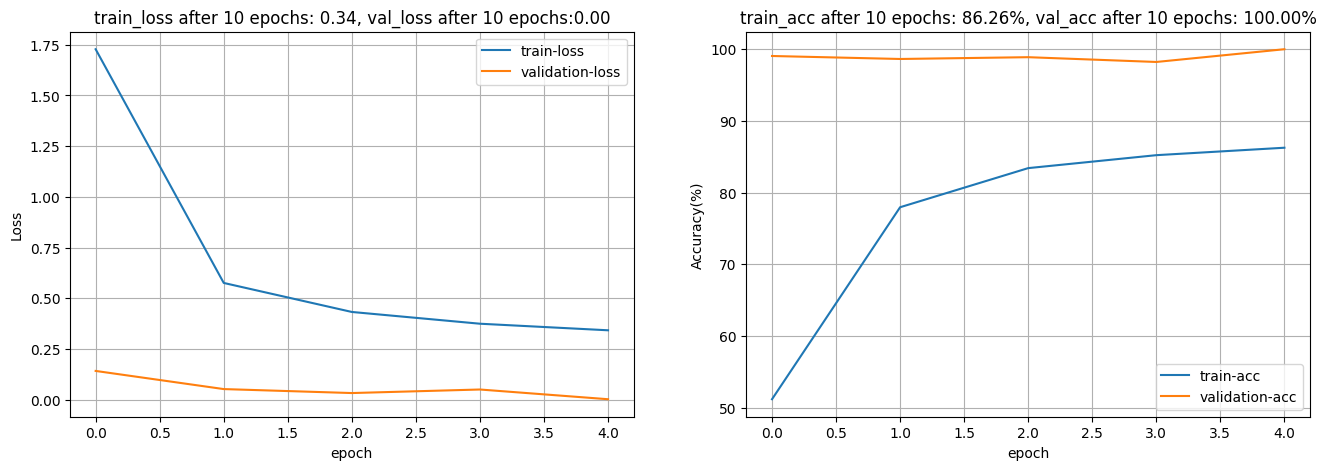

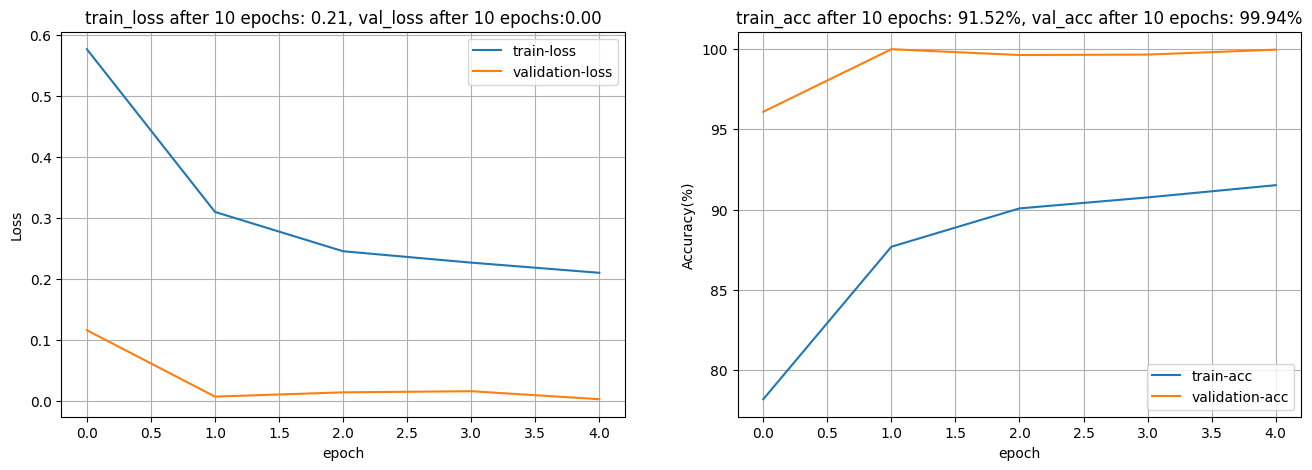

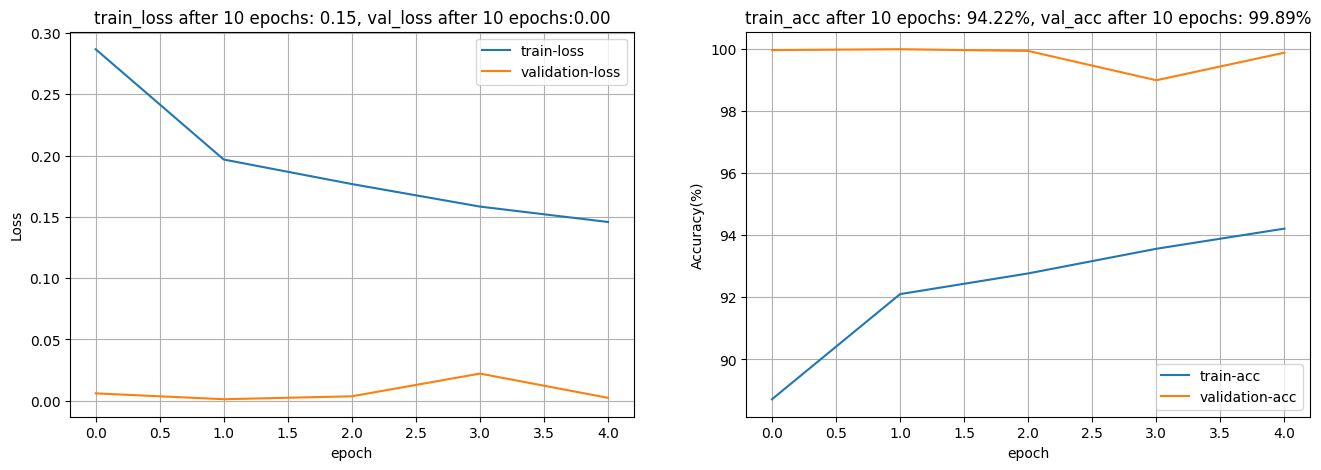

In [168]:
plot_loss_and_accuracies(base_train_loss,base_val_loss,base_train_acc,base_val_acc)
plot_loss_and_accuracies(sc_train_loss,sc_val_loss,sc_train_acc,sc_val_acc)
plot_loss_and_accuracies(tf_train_loss,tf_val_loss,tf_train_acc,tf_val_acc)

In [ ]:
plot_loss_and_accuracies(base_train_loss2,base_val_loss2,base_train_acc2,base_val_acc2)

In [171]:
trained_model1 = basemodel()
trained_model1.load_state_dict(results['base_model']['model'].state_dict())
#Model with the orientations displayed now
#trained_model1_1.load_state_dict(second_results['base_model']['model'].state_dict())


trained_model2 = models.resnet18()
trained_model2.fc = nn.Linear(trained_model2.fc.in_features, 6)

trained_model3 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
trained_model3.fc = nn.Linear(trained_model2.fc.in_features, 6)

trained_model2.load_state_dict(results['resnet_sc']['model'].state_dict())
trained_model3.load_state_dict(results['resnet_w']['model'].state_dict())

<All keys matched successfully>

In [172]:
def plot_classification_report_by_metric_fulldata(dataloader, model_dict, model_names, device='cpu'):
    model_predictions = {name: [] for name in model_names}
    y_true = []

    # Set all models to evaluation mode and move to device
    for model in model_dict.values():
        model.eval()
        model.to(device)

    # Loop through the entire DataLoader
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            y_true.append(labels.cpu().numpy())

            # Get predictions from each model
            for name, model in model_dict.items():
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                model_predictions[name].append(preds.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.concatenate(y_true)
    for name in model_names:
        model_predictions[name] = np.concatenate(model_predictions[name])

    metrics = ['precision', 'recall', 'f1-score', 'accuracy']
    report_data = {metric: [] for metric in metrics}

    for name in model_names:
        y_pred = model_predictions[name]
        report = classification_report(y_true, y_pred, output_dict=True)
        labels = list(report.keys())[:-3]

        for metric in metrics[:-1]:
            average_metric_value = np.mean([report[label][metric] for label in labels if label not in ['accuracy', 'macro avg', 'weighted avg']])
            report_data[metric].append(average_metric_value *100)

        report_data['accuracy'].append(report['accuracy']*100)

    x = np.arange(len(metrics))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    positions = [-width, 0, width]

    for i, model_name in enumerate(model_names):
        bars = ax.bar(x + positions[i], [report_data[metric][i] for metric in metrics], width, label=model_name, color=colors[i])
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores(%)')
  #  ax.set_title('Classification Metrics for Multiple Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend(loc='lower left')

    plt.tight_layout()
    plt.show()


In [173]:
model_dict = {
    'Base_Model': trained_model1,
    #'ResNet18': trained_model2,
   # 'ResNet18_w_Weights': trained_model3
}

plot_classification_report_by_metric_fulldata(test_loader, model_dict, ['Base_Model'])

NameError: name 'classification_report' is not defined

In [ ]:
basetest_acc = test_model(trained_model1)
rssctest_acc = test_model(trained_model2)
rswtest_acc = test_model(trained_model3)

In [ ]:
test_loss_and_acc(basetest_acc)

In [ ]:
test_loss_and_acc(trained_model2)

In [ ]:
test_loss_and_acc(trained_model3)